In [26]:
import os
import numpy as np
import pandas as pd
import sys
import pickle
from tqdm.notebook import tqdm, trange
import rdkit 
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import mols2grid

In [11]:
# define paths
notebook_path = os.path.realpath(os.getcwd())
root_dir_path = os.path.dirname(notebook_path)
code_path = root_dir_path + os.sep + "VirtuousMultiTaste" + os.sep
src_path = code_path + os.sep + "src" + os.sep
data_path = root_dir_path + os.sep + "data" + os.sep


In [12]:
# import Virtuous Library
sys.path.append(code_path)
import Virtuous

In [13]:
Virtuous.__version__

'1.9'

## Load DBs

In [14]:
# path to the file in the Dropbox folder 
fourTaste_train_file = data_path +  "training_dataset_fourtaste_problem.csv"
fourTaste_test_file  = data_path +  "testing_dataset_fourtaste_problem.csv"

In [55]:
DB_train = pd.read_csv(fourTaste_train_file, sep="\t", low_memory=False)
DB_test  = pd.read_csv(fourTaste_test_file,  sep="\t", low_memory=False)
DB = pd.concat([DB_train, DB_test], axis=0)

In [54]:
DB

<bound method DataFrame.reset_index of       Unnamed: 0      Taste  \
0              0      Umami   
1              1     Bitter   
2              2  Tasteless   
3              3      Sweet   
4              4      Sweet   
...          ...        ...   
3405        3405      Sweet   
3406        3406      Sweet   
3407        3407      Sweet   
3408        3408      Sweet   
3409        3409     Bitter   

                                             Std_SMILES  \
0     C[C@H](NC(=O)[C@@H]1CCCN1)C(=O)N[C@@H](CCC(N)=...   
1                                       OC/C=C/c1ccccc1   
2                     COc1ccc(C(=O)c2ccccc2C(=O)O)cc1OC   
3                        CC(C)CC1OC(CC(C)C)OC(CC(C)C)O1   
4                 C=CC(C)(CCC=C(C)C)OC(=O)/C=C/c1ccccc1   
...                                                 ...   
3405                             O=C1NS(=O)(=O)c2cscc12   
3406          COCC(NC(=Nc1ccc(C#N)cc1)NCC(=O)O)c1ccccc1   
3407                  CC(C)(C)OC(=O)CCNC(=O)C(N)CC(=O)O  

In [17]:
print ("Number of all compounds in the dataset: %d" %DB.shape[0])
print ("\nNumber of compounds in the training set: %d" %DB_train.shape[0])
print ("Number of compounds in the testing  set: %d" %DB_test.shape[0])
print ("\nNumber of SWEET compounds in the training set: %d" %(DB_train["Taste"]=="Sweet").sum())
print ("Number of SWEET compounds in the testing  set: %d" %(DB_test["Taste"]=="Sweet").sum())
print ("\nNumber of BITTER compounds in the training set: %d" %(DB_train["Taste"]=="Bitter").sum())
print ("Number of BITTER compounds in the testing  set: %d" %(DB_test["Taste"]=="Bitter").sum())
print ("\nNumber of UMAMI compounds in the training set: %d" %(DB_train["Taste"]=="Umami").sum())
print ("Number of UMAMI compounds in the testing  set: %d" %(DB_test["Taste"]=="Umami").sum())
print ("\nNumber of TASTELESS compounds in the training set: %d" %(DB_train["Taste"]=="Tasteless").sum())
print ("Number of TASTELESS compounds in the testing  set: %d" %(DB_test["Taste"]=="Tasteless").sum())

Number of all compounds in the dataset: 4717

Number of compounds in the training set: 1307
Number of compounds in the testing  set: 3410

Number of SWEET compounds in the training set: 360
Number of SWEET compounds in the testing  set: 1544

Number of BITTER compounds in the training set: 360
Number of BITTER compounds in the testing  set: 1577

Number of UMAMI compounds in the training set: 227
Number of UMAMI compounds in the testing  set: 0

Number of TASTELESS compounds in the training set: 360
Number of TASTELESS compounds in the testing  set: 289


In [56]:
DB_train = DB_train.reset_index()
DB_test  = DB_test.reset_index()
DB = DB.reset_index()

## Define the Applicability Domain of Umami DB

In [57]:
AD_train_file = src_path + os.sep + "fourtaste_AD_train.pkl"
AD_file = src_path + os.sep + "fourtaste_AD.pkl"

AD_train = Virtuous.DefineAD(DB_train, smile_field="Parent_SMILES", output_filename=AD_train_file)
AD = Virtuous.DefineAD(DB, smile_field="Parent_SMILES", output_filename=AD_file)

#### Define number of neighbors

In [20]:
vicini = 5
metric = "tanimoto"

## Retrieve threshold for the AD definition

#### Training-Training comparison

In [21]:
train_scores = []

# cycle over the Umami DB
for i in tqdm(range(len(DB_train))):
        
    # calculate the average similarity score of all compounds with the umami AD
    test, score, sim_smiles = Virtuous.TestAD(DB_train.Parent_SMILES[i], filename=AD_train_file, verbose = False, neighbors = vicini, metric=metric) 
    train_scores.append(score)

  0%|          | 0/1307 [00:00<?, ?it/s]

#### Training-Testing comparison

In [22]:
test_scores = []

# cycle over the Umami DB
for i in tqdm(range(len(DB_test))):
        
    # calculate §average similarity score of all umami compounds with the umami AD
    test, score, sim_smiles = Virtuous.TestAD(DB_test.Parent_SMILES[i], filename=AD_train_file, verbose = False, neighbors = vicini, metric = metric) 
    test_scores.append(score)

  0%|          | 0/3410 [00:00<?, ?it/s]

#### Plot Scores

In [23]:
all_scores = train_scores + test_scores

index_train = ["Train vs Train"] * len(train_scores)
index_test  = ["Test vs Train"]  * len(test_scores)
all_index   = index_train + index_test

df = pd.DataFrame()
df["data"] = all_scores
df["index"] = all_index

threshold = np.min(all_scores)
print ("Setting similarity threshold to %.3f" %threshold)

Setting similarity threshold to 0.032


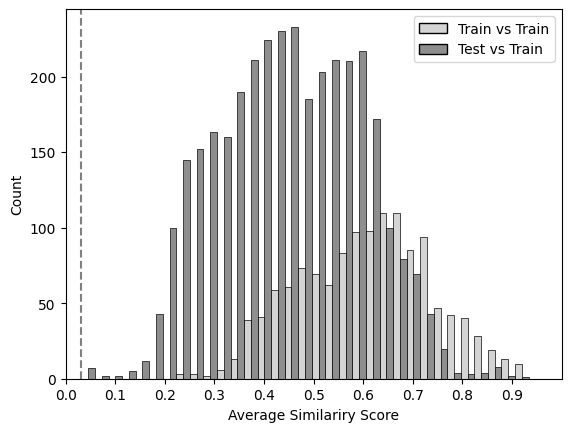

In [24]:
g = sns.histplot(data = df, x = "data", hue = "index", palette="Greys", multiple="dodge", shrink=1, stat = 'count')
g.legend_.set_title(None)
plt.axvline(threshold, 0, 60 , color='grey', linestyle = '--')
plt.xlabel("Average Similariry Score")
plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))
plt.savefig(data_path + "AD_Train_vs_Test.png", dpi=300)
plt.show()

- ***Similar distribution between Training and Dataset, showing that the dataset is pretty similar to the training set distribution***
- ***High values of similarities showing that compounds in the train and test sets are similar*** 

## Import query molecule

In [34]:
query_smile = "CC1=CC(=O)C2=C(C)CC[C@@H]3[C@H](OC(=O)[C@@H]3C)[C@@H]12"
#query_smile = DB.Parent_SMILES[0]
#query_smile = "C(CC(=O)O)C(C(=O)[O-])N.[Na+]"
#query_smile =  "C(CC(=O)[O-])C(C(=O)[O-])[NH3+]"# glutammate

issues, std_smi, parent_smi = Virtuous.Standardize(Virtuous.ReadMol(query_smile, verbose=False))
mols = [Virtuous.ReadMol(query_smile, verbose=False), Virtuous.ReadMol(std_smi, verbose=False), Virtuous.ReadMol(parent_smi, verbose=False)]
mols2grid.display(mols, fixedBondLength=60, template="table", fontsize="10pt", prerender=True)

MolGridWidget()

### Test the AD: calculate Similarities between query compound and Umami DB

In [60]:
test, score, sim_smiles = Virtuous.TestAD(query_smile, filename= src_path + os.sep + "fourtaste_AD.pkl", verbose = True, sim_threshold=threshold, neighbors = vicini, metric = metric)
print ("Score is: %.3f" %score)

OK: The query compound is inside the Applicability Domain!
Score is: 0.473


In [62]:
mols = [Virtuous.ReadMol(smile, verbose=False) for smile in sim_smiles]
mols2grid.display(mols, fixedBondLength=60, template="table", fontsize="10pt", prerender=True)

MolGridWidget()

Input has been interpeted as SMILES


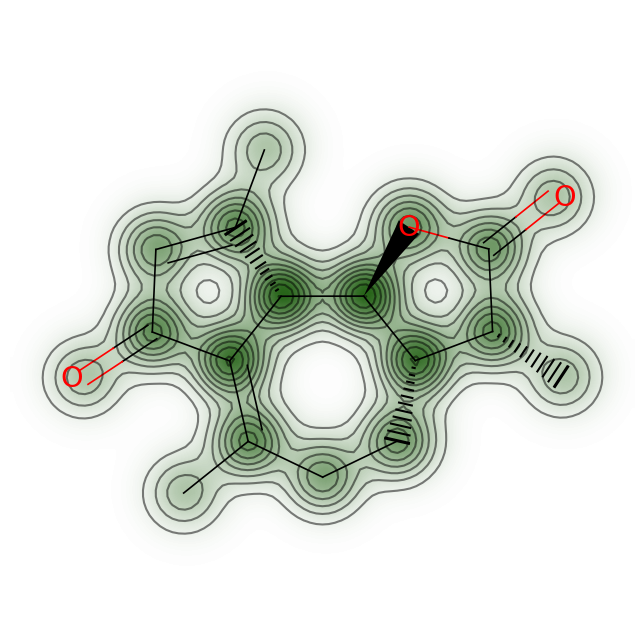

In [63]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(mols[0], Virtuous.ReadMol(parent_smi), SimilarityMaps.GetMorganFingerprint)

In [64]:
print ("The 5 most similar compounds in the Umami DB result in an average similarity score of %.2f and they are \n%s" %(score, sim_smiles))

The 5 most similar compounds in the Umami DB result in an average similarity score of 0.47 and they are 
['CC1=CC(=O)C2=C(C)CC[C@@H]3[C@H](OC(=O)[C@@H]3C)[C@@H]12'
 'C=C1C(=O)O[C@H]2[C@H]1CCC(C)=C1C(=O)C=C(CO)[C@@H]12'
 'CC1=C2C(=O)C=C(CO)[C@@H]2[C@H]2OC(=O)[C@@H](C)[C@@H]2[C@@H](O)C1'
 'C=C1C(=O)O[C@H]2[C@H]1CCC(C)=C1C(=O)C=C(COS(=O)(=O)O)[C@H]12'
 'CC(=O)OC[C@H]1CC=C(C)[C@@H](OC(C)=O)C[C@@H]2[C@@H](C=C1C)OC(=O)[C@@H]2C']


## Test External DB against Umami DB

In [68]:
Dropbox = "/Users/lorenzo/Dropbox (Politecnico Di Torino Studenti)/VIRTUOUS/"
externalDBs_path = Dropbox + "data/03-External_DBs/"

In [70]:
FlavorDB = pd.read_csv(externalDBs_path + "FlavorDB/00-starting_files/01-FlavorDB_checked.csv", sep=";", low_memory=False)
FoodDB   = pd.read_csv(externalDBs_path + "FoodDB/00-starting_files/01-FoodDB_checked.csv", sep=";", low_memory=False)
NPAtlas  = pd.read_csv(externalDBs_path + "NPAtlas_v2021_08/00-starting_files/01-NPAtlas_v2021_08_checked.csv", sep=";", low_memory=False)
PhenolExplorer = pd.read_csv(externalDBs_path + "PhenolExplorer3.6/00-starting_files/01-PhenolExplorer3.6_checked.csv", sep=";", low_memory=False)
PhytoHub = pd.read_csv(externalDBs_path + "PhytoHub1.4/00-starting_files/01-PhytoHub1.4_checked.csv", sep=";", low_memory=False)

In [27]:
#FlavorDB = pd.read_csv(externalDBs_path + "FlavorDB/01-descriptors/02-FlavorDB_Mordred_RDKit_pybel.csv", sep=";", low_memory=False)
#FoodDB   = pd.read_csv(externalDBs_path + "FoodDB/01-desciptors/02-FoodDB_Mordred_RDKit_pybel.csv", sep=";", low_memory=False)
#NPAtlas  = pd.read_csv(externalDBs_path + "NPAtlas_v2021_08/01-descriptors/02-NPAtlas_v2021_08_Mordred_RDKit_pybel.csv", sep=";", low_memory=False)
#PhenolExplorer = pd.read_csv(externalDBs_path + "PhenolExplorer3.6/01-descriptors/02-PhenolExplorer3.6_Mordred_RDKit_pybel.csv", sep=";", low_memory=False)
#PhytoHub = pd.read_csv(externalDBs_path + "PhytoHub1.4/01-descriptors/02-PhytoHub1.4_Mordred_RDKit_pybel.csv", sep=";", low_memory=False)

In [74]:
def testAD_DB (DB, smile_field = "Parent_SMILES", sim_threshold=0.1):
    
    tests = []
    similarity_scores = []
    similarity_smiles = []

    for i in tqdm(range(len(DB))):
    
        query_smile = DB[smile_field][i]
    
        # test AD
        test, sim_score, sim_smile = Virtuous.TestAD(query_smile, filename=src_path + os.sep + "fourtaste_AD.pkl", verbose = False, sim_threshold=sim_threshold)
    
        tests.append(test)
        similarity_scores.append(sim_score)
        similarity_smiles.append(sim_smile)  
        
    inside  = sum(tests)
    outside = len(tests)-inside
    inside_percent = sum(tests)/len(tests)*100
    inside_smiles = DB[smile_field][tests]
    
    return inside, outside, inside_percent, inside_smiles

In [72]:
threshold

0.03191609845011642

In [75]:
inside_FlavorDB, outside_FlavorDB, inside_percent_FlavorDB, inside_smiles_FlavorDB = testAD_DB(FlavorDB, sim_threshold=threshold)
inside_FoodDB,   outside_FoodDB, inside_percent_FoodDB, inside_smiles_FoodDB = testAD_DB(FoodDB, sim_threshold=threshold)
inside_NPAtlas,  outside_NPAtlas, inside_percent_NPAtlas, inside_smiles_NPAtlas = testAD_DB(NPAtlas, sim_threshold=threshold)
inside_PhenolExplorer, outside_PhenolExplorer, inside_percent_PhenolExplorer, inside_smiles_PhenolExplorer = testAD_DB(PhenolExplorer, sim_threshold=threshold)
inside_PhytoHub, outside_PhytoHub, inside_percent_PhytoHub, inside_smiles_PhytoHub = testAD_DB(PhytoHub, sim_threshold=threshold)

  0%|          | 0/2599 [00:00<?, ?it/s]

  0%|          | 0/69309 [00:00<?, ?it/s]

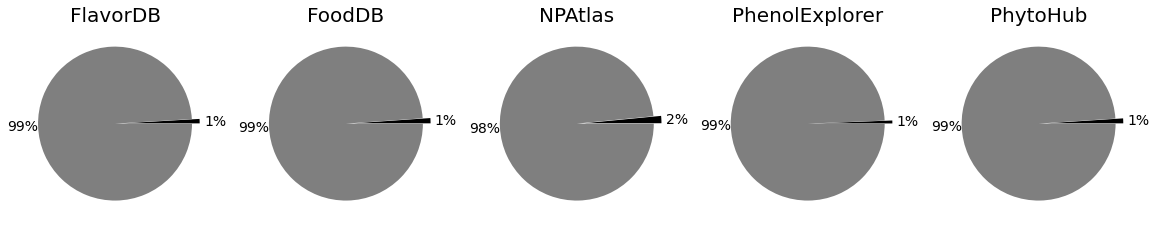

In [32]:
# Some data
DBs = ["FlavorDB", "FoodDB", "NPAtlas", "PhenolExplorer", "PhytoHub"]

labels = 'Inside', 'Outside'

fracs = []
fracs.append([inside_FlavorDB, outside_FlavorDB])
fracs.append([inside_FoodDB, outside_FoodDB])
fracs.append([inside_NPAtlas, outside_NPAtlas])
fracs.append([inside_PhenolExplorer, outside_PhenolExplorer])
fracs.append([inside_PhytoHub, outside_PhytoHub])

# Make figure and axes
fig, axs = plt.subplots(1, len(DBs), figsize=(20,4))

# Shift the second slice using explode
for i in range(len(DBs)): 
    axs[i].pie(fracs[i], autopct='%.0f%%', shadow=False, explode=(0.1, 0), colors=(["k", "tab:grey"]), pctdistance=1.2, textprops={'fontsize': 14})#, labeldistance=1.2, labels=labels)
    axs[i].set_title(DBs[i], fontsize=20)

fig.set_facecolor('white')
#plt.suptitle("Threshold %.1f" %threshold)
plt.savefig("AD_ExternalDBs.png", dpi=300)
plt.show()

In [33]:
print ("FlavorDB: %.2f%% (%d/%d)" %(inside_percent_FlavorDB, inside_FlavorDB, inside_FlavorDB + outside_FlavorDB))
print ("FoodDB:   %.2f%% (%d/%d)" %(inside_percent_FoodDB, inside_FoodDB, inside_FoodDB + outside_FoodDB))
print ("NPAtlas:  %.2f%% (%d/%d)" %(inside_percent_NPAtlas, inside_NPAtlas, inside_NPAtlas + outside_NPAtlas))
print ("PhenoExp: %.2f%% (%d/%d)" %(inside_percent_PhenolExplorer, inside_PhenolExplorer, inside_PhenolExplorer + outside_PhenolExplorer))
print ("PhytoHub: %.2f%% (%d/%d)" %(inside_percent_PhytoHub, inside_PhytoHub, inside_PhytoHub + outside_PhytoHub))

FlavorDB: 0.92% (24/2599)
FoodDB:   1.09% (757/69309)
NPAtlas:  1.52% (495/32491)
PhenoExp: 0.61% (3/489)
PhytoHub: 1.03% (18/1746)


### Take only the inside part of the External DBs and calculate descriptors

In [34]:
processed_DBs = [FlavorDB, FoodDB, NPAtlas, PhenolExplorer, PhytoHub]
DB_names = ["FlavorDB", "FoodDB", "NPAtlas_v2021_08", "PhenolExplorer3.6", "PhytoHub1.4"]
inside_smiles_DBs = [inside_smiles_FlavorDB, inside_smiles_FoodDB, inside_smiles_NPAtlas, inside_smiles_PhenolExplorer, inside_smiles_PhytoHub]

In [35]:
export_path = Dropbox + "data/03-External_DBs/"

In [54]:
DB_desc_list = []
DB_desc_mord_list = []

for i in range(len(processed_DBs)):
    
    print ("Processing %s" %DB_names[i])
    
    actual_DB = processed_DBs [i]
    actual_DB_name = DB_names [i]

    file_desc = export_path + actual_DB_name + "/02-AD/03-" + actual_DB_name + "_Mordred_RDKit_pybel.csv"
    DB_desc_list.append(Virtuous.CalcDesc_DB (actual_DB.iloc[inside_smiles_DBs[i].index].reset_index(), output=file_desc, smile_field = "Parent_SMILES", sep = ";", Mordred=True, RDKit=True, pybel=True))

    file_desc = export_path + actual_DB_name + "/02-AD/03-" + actual_DB_name + "_Mordred.csv"
    DB_desc_mord_list.append(Virtuous.CalcDesc_DB (actual_DB.iloc[inside_smiles_DBs[i].index].reset_index(), output=file_desc, smile_field = "Parent_SMILES", sep = ";", Mordred=True, RDKit=False, pybel=False))

Processing FlavorDB


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing FoodDB


  0%|          | 0/757 [00:00<?, ?it/s]

/home/lorenzo/anaconda3/envs/VIRTUOUS/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  0%|          | 0/757 [00:00<?, ?it/s]

Processing NPAtlas_v2021_08


  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/495 [00:00<?, ?it/s]

Processing PhenolExplorer3.6


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Processing PhytoHub1.4


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]